In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv("../data/AllMoviesDetailsCleaned.csv", encoding='utf-8-sig', sep=";")

/tmp/ipykernel_25759/2602094491.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/AllMoviesDetailsCleaned.csv", encoding='utf-8-sig', sep=";")


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329044 entries, 0 to 329043
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   id                           329044 non-null  int64         
 1   budget                       329044 non-null  int64         
 2   genres                       207515 non-null  object        
 3   imdb_id                      250564 non-null  object        
 4   original_language            328841 non-null  object        
 5   original_title               329043 non-null  object        
 6   overview                     278060 non-null  object        
 7   popularity                   329044 non-null  object        
 8   production_companies         329044 non-null  object        
 9   production_countries         329044 non-null  object        
 10  release_date                 304998 non-null  datetime64[ns]
 11  revenue                   

In [18]:
DISPLAY_WIDTH = 400
DISPLAYMAX_COLUMNS = 25
pd.set_option('display.width', DISPLAY_WIDTH)
pd.set_option('display.max_columns', DISPLAYMAX_COLUMNS)
df.describe()

,id,budget,revenue,runtime,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number
count,329044.000000,3.290440e+05,3.290440e+05,292252.000000,329044.000000,329044.000000,329044.00000,329044.000000,329044.000000
mean,252984.152937,6.129073e+05,1.533838e+06,60.406813,2.374474,14.211270,0.59475,0.609882,0.647628
std,138633.855160,6.845307e+06,2.401891e+07,142.502210,3.126254,166.443851,1.03807,0.664861,0.672048
min,2.000000,0.000000e+00,-1.200000e+01,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,124796.250000,0.000000e+00,0.000000e+00,5.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,276473.500000,0.000000e+00,0.000000e+00,71.000000,0.000000,0.000000,0.00000,1.000000,1.000000
75%,370839.250000,0.000000e+00,0.000000e+00,94.000000,5.500000,1.000000,1.00000,1.000000,1.000000
max,469219.000000,6.000000e+08,2.781506e+09,51420.000000,10.000000,12811.000000,26.00000,26.000000,25.000000


<AxesSubplot:>

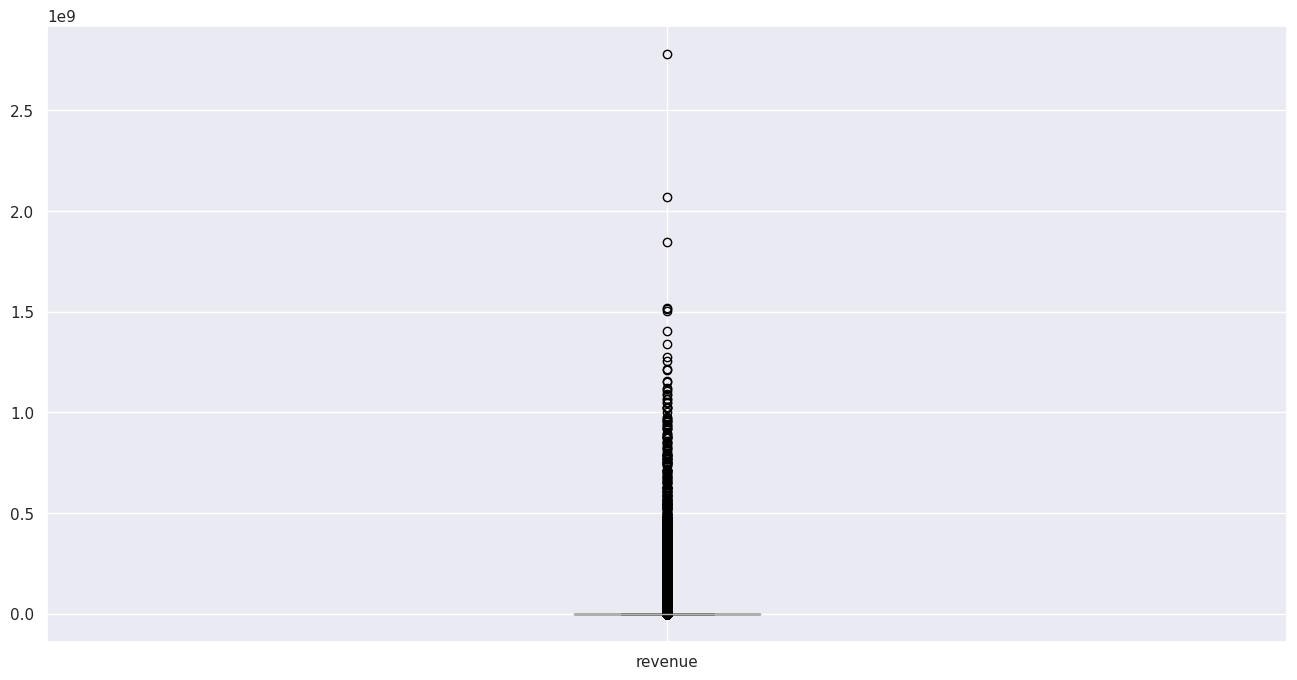

In [19]:
df[['revenue']].boxplot(figsize=(16,8))

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'budget'}>,
        <AxesSubplot:title={'center':'revenue'}>],
       [<AxesSubplot:title={'center':'runtime'}>,
        <AxesSubplot:title={'center':'vote_average'}>,
        <AxesSubplot:title={'center':'vote_count'}>],
       [<AxesSubplot:title={'center':'production_companies_number'}>,
        <AxesSubplot:title={'center':'production_countries_number'}>,
        <AxesSubplot:title={'center':'spoken_languages_number'}>]],
      dtype=object)

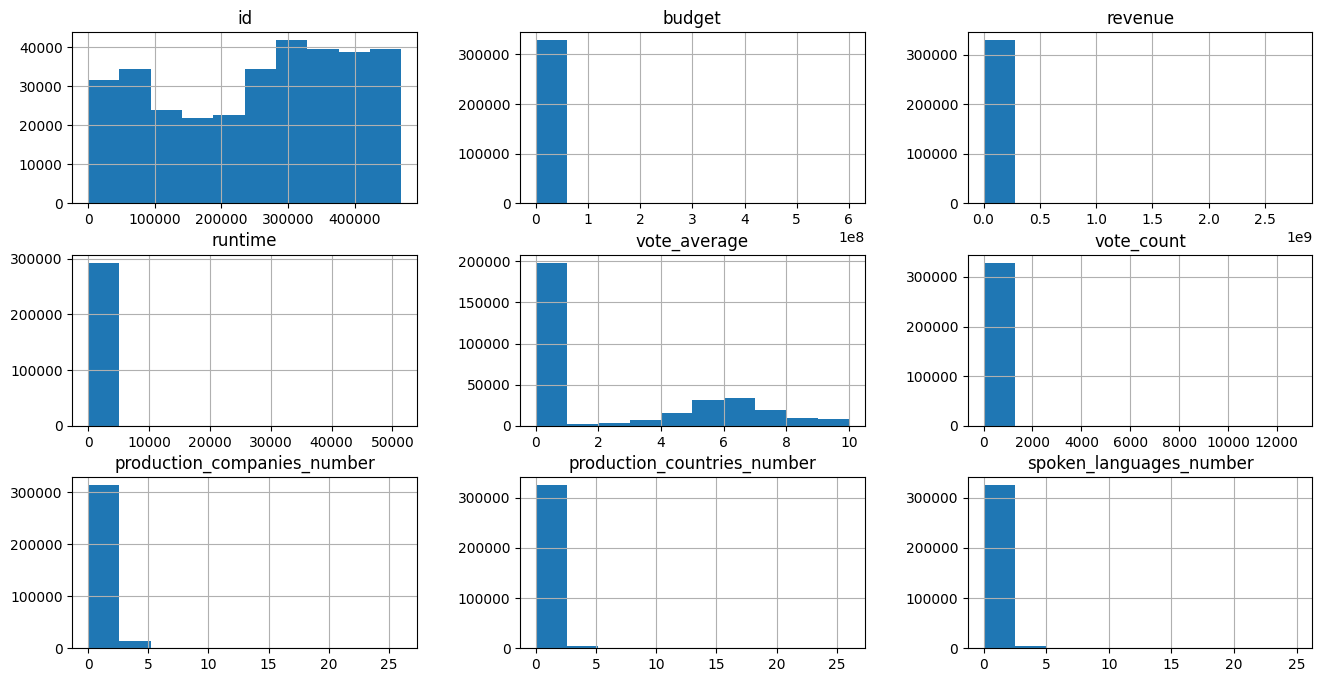

In [11]:
df.hist(figsize=(16,8))

In [ ]:
#sns.pairplot(df)

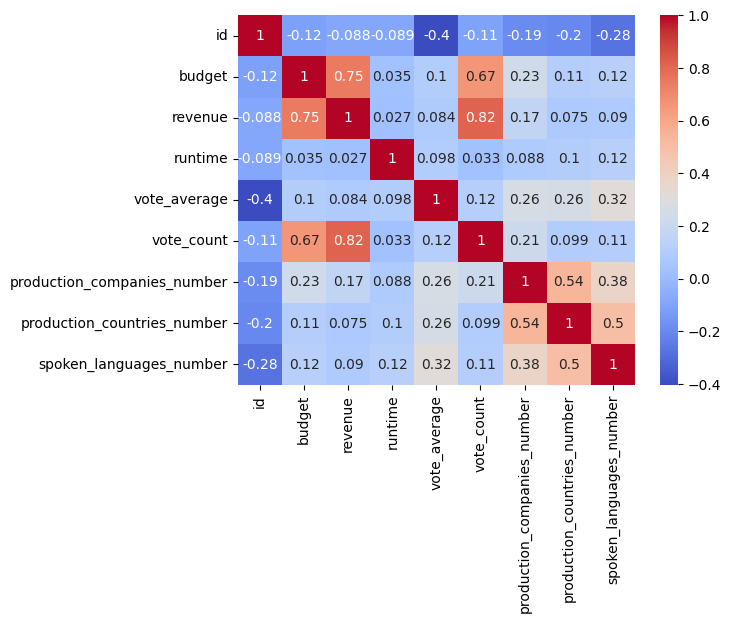

In [13]:
sns.heatmap(df.corr(),cmap='coolwarm',annot=True)
sns.set(rc={'figure.figsize':(8,8)})

In [24]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import FunctionTransformer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator

from sklearn.pipeline import FeatureUnion
from sklearn.impute import SimpleImputer

In [25]:
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

In [26]:
X = df.drop(columns=['revenue'])
y = df[['revenue']]

In [29]:
df_cat=df.select_dtypes("object")
df_melt = pd.melt(df, value_vars=df_cat.columns)
feat_categorical_nunique=df_melt.groupby("variable").nunique()
#feat_categorical_nunique

In [30]:
feat_categorical_small=feat_categorical_nunique[feat_categorical_nunique<7].dropna()

In [31]:
num_pipeline = Pipeline([
    ('imputer_num', SimpleImputer(strategy="mean")),
    ('std_scaler', MinMaxScaler()),

])

cat_pipeline = Pipeline([
    ('imputer_cat', SimpleImputer(strategy="most_frequent")),
    ('ohc', OneHotEncoder(handle_unknown='ignore',sparse=False)),
])


preproc_baseline = ColumnTransformer([
    ("num", num_pipeline, make_column_selector(dtype_include=np.number)),
    ("cat", cat_pipeline, list(feat_categorical_small.index)),
])
preproc_baseline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer_num',
                                                  SimpleImputer()),
                                                 ('std_scaler',
                                                  MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f05de9e88e0>),
                                ('cat',
                                 Pipeline(steps=[('imputer_cat',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohc',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['status'])])

In [32]:
X_proc=preproc_baseline.fit_transform(X)

In [33]:
xgb_params = dict(
    max_depth=6,           # maximum depth of each tree - try 2 to 10
    learning_rate=0.01,    # effect of each tree - try 0.0001 to 0.1
    n_estimators=1000,     # number of trees (that is, boosting rounds) - try 1000 to 8000
    min_child_weight=1,    # minimum number of houses in a leaf - try 1 to 10
    colsample_bytree=0.7,  # fraction of features (columns) per tree - try 0.2 to 1.0
    subsample=0.7,         # fraction of instances (rows) per tree - try 0.2 to 1.0
    reg_alpha=0.5,         # L1 regularization (like LASSO) - try 0.0 to 10.0
    reg_lambda=1.0,        # L2 regularization (like Ridge) - try 0.0 to 10.0
    num_parallel_tree=1,   # set > 1 for boosted random forests
)

pipe_baseline = Pipeline([
    ('preps', preproc_baseline),
    # ('model', LinearRegression()),
    #('model', DecisionTreeRegressor()),
    #('estimator', xgb.XGBRegressor(max_depth=10, n_estimators=500, learning_rate=0.1)
    ('estimator', xgb.XGBRegressor(**xgb_params)
),

])

In [34]:
from sklearn.model_selection import cross_validate
cv=cross_validate(pipe_baseline,X,y,cv=5,scoring='r2')  #compare this with  lin_reg.fit(X_train_prepared, y_train)
score_baseline=cv["test_score"].mean()
score_baseline

KeyboardInterrupt: 